In [1]:
import cv2
import numpy as np

In [2]:
template = cv2.imread('./images/lane.png')

In [10]:
a = np.mean(template, axis=2)

In [13]:
a[0][0]

47.0

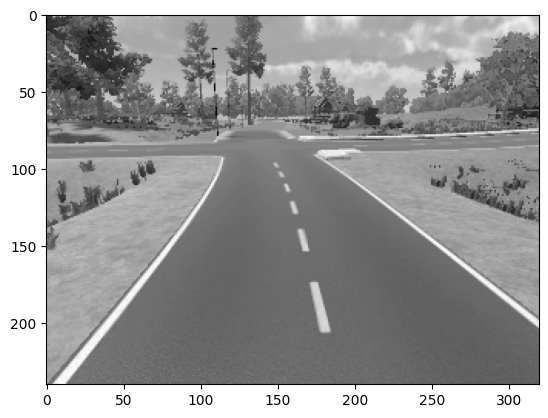

In [15]:
import matplotlib.pyplot as plt
plt.imshow(np.mean(template, axis=2), cmap='gray')

In [16]:
#sobel filter numpy
sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_filter_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

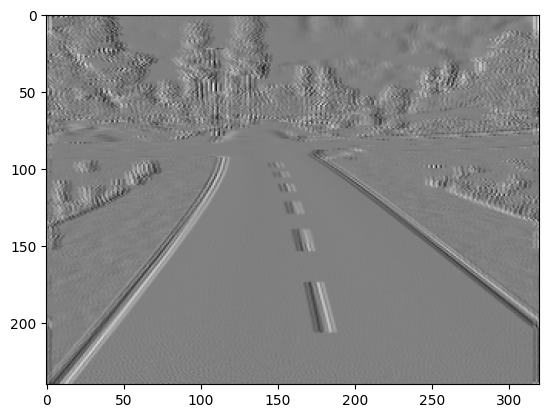

In [23]:
sobel_x = np.convolve(a.flatten(), sobel_filter_x.flatten(), mode='same').reshape(a.shape)
plt.imshow(sobel_x, cmap='gray')

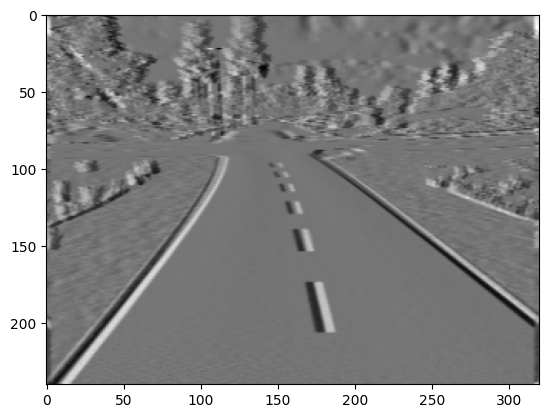

In [24]:
sobel_y = np.convolve(a.flatten(), sobel_filter_y.flatten(), mode='same').reshape(a.shape)
plt.imshow(sobel_y, cmap='gray')

In [1]:
%load_ext autoreload
%autoreload 2
import math

import numpy
import numpy as np
import cv2
import matplotlib.pyplot as plt

from src.image import Image, GrayImage
from src.utils import keep_pixel_np, sobel_filter_x, sobel_filter_y
from src.seq import SeqGeneralHoughTransform

THRESHOLD = 200
IMAGE_DIR = './images'


In [2]:
template = cv2.imread(f"{IMAGE_DIR}/lane.png")
template = Image(template.shape[1], template.shape[0], template)
a = SeqGeneralHoughTransform(None, template)
gray_src = GrayImage(template.data.shape[1], template.data.shape[0])
a.convertToGray(template, gray_src)
magnitude_x = GrayImage(template.data.shape[1], template.data.shape[0])
magnitude_y = GrayImage(template.data.shape[1], template.data.shape[0])
magnitude = GrayImage(template.data.shape[1], template.data.shape[0])
a.convolve(sobel_filter_x, gray_src, magnitude_x, 'x')
a.convolve(sobel_filter_y, gray_src, magnitude_y, 'y')
a.magnitude(magnitude_x, magnitude_y, magnitude)
orientation = GrayImage(template.data.shape[1], template.data.shape[0])
a.orientation(magnitude_x, magnitude_y, orientation)
edge_minmax = GrayImage(template.data.shape[1], template.data.shape[0])
a.edgemns(magnitude, orientation, edge_minmax)
mag_threshold = GrayImage(template.data.shape[1], template.data.shape[0])
a.threshold(edge_minmax, mag_threshold, THRESHOLD)

In [20]:
N_ROTATION_SLICES = 72
DELTA_ROTATION_ANGLE = 360 / N_ROTATION_SLICES
indices_j, indices_i = np.where(mag_threshold.data == 255)
phi = np.fmod(orientation.data[indices_j, indices_i], 360)
i_slice = (phi / DELTA_ROTATION_ANGLE).astype(int)
center_x = orientation.width // 2
center_y = orientation.height // 2
entry_x = center_x - indices_i
entry_y = center_y - indices_j
r = np.sqrt(entry_x ** 2 + entry_y ** 2)
alpha = np.arctan2(entry_y, entry_x)
r_table = [[] for _ in range(N_ROTATION_SLICES)]
for i in range(len(indices_i)):
    entry = {'r': r[i], 'alpha': alpha[i]}
    r_table[i_slice[i]].append(entry)

In [21]:
r_table

[[{'r': 122.3315167894194, 'alpha': 1.0009323233015779},
  {'r': 162.28986413205232, 'alpha': 0.6102211688742866},
  {'r': 88.81441324469807, 'alpha': 0.9453112865556675},
  {'r': 88.0056816347672, 'alpha': 0.938658365265903},
  {'r': 93.39164844888434, 'alpha': 2.9147938055359073}],
 [{'r': 180.75950874020432, 'alpha': 2.601173153319209},
  {'r': 93.62157870918435, 'alpha': 2.904385854706149},
  {'r': 132.03408650799233, 'alpha': 3.118869292748152}],
 [{'r': 173.0664612222715, 'alpha': 0.5880026035475675},
  {'r': 164.21023110634732, 'alpha': 0.5728010719096839},
  {'r': 102.61578825892242, 'alpha': 0.9097531579442097},
  {'r': 74.72616676907762, 'alpha': 1.8417431771333173},
  {'r': 73.08214556237385, 'alpha': 1.2793395323170296},
  {'r': 166.9281282468596, 'alpha': 0.42613170734697253},
  {'r': 65.45991139621256, 'alpha': 1.8973777614855152},
  {'r': 161.1862276995153, 'alpha': 0.37474607216072614},
  {'r': 61.554853586049575, 'alpha': 2.390663591191853}],
 [{'r': 112.36102527122117